##V1 Final Capstone

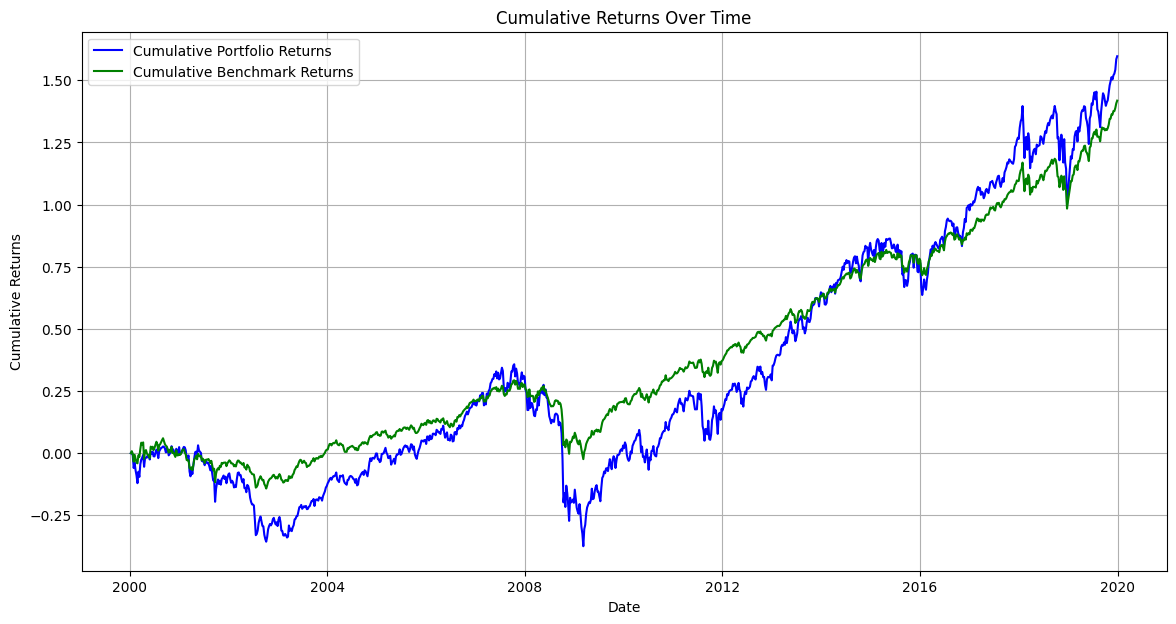

Total Return of the Portfolio: 159.68%
Annualized Return of the Portfolio: 4.89%
Sharpe Ratio of the Portfolio: 0.37699299791845314
Volatility of the Portfolio: 16.09%
Maximum Drawdown of the Portfolio: -73.20%
Alpha of the Portfolio: 0.01%
Beta of the Portfolio: 1.95
Total Return of the Benchmark: 141.82%
Annualized Return of the Benchmark: 4.52%
Sharpe Ratio of the Benchmark: 0.6219823821578575
Volatility of the Benchmark: 7.54%
Maximum Drawdown of the Benchmark: -31.71%


<ipython-input-11-0412071e30cd>:169: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simulation_df[x] = portfolio_values


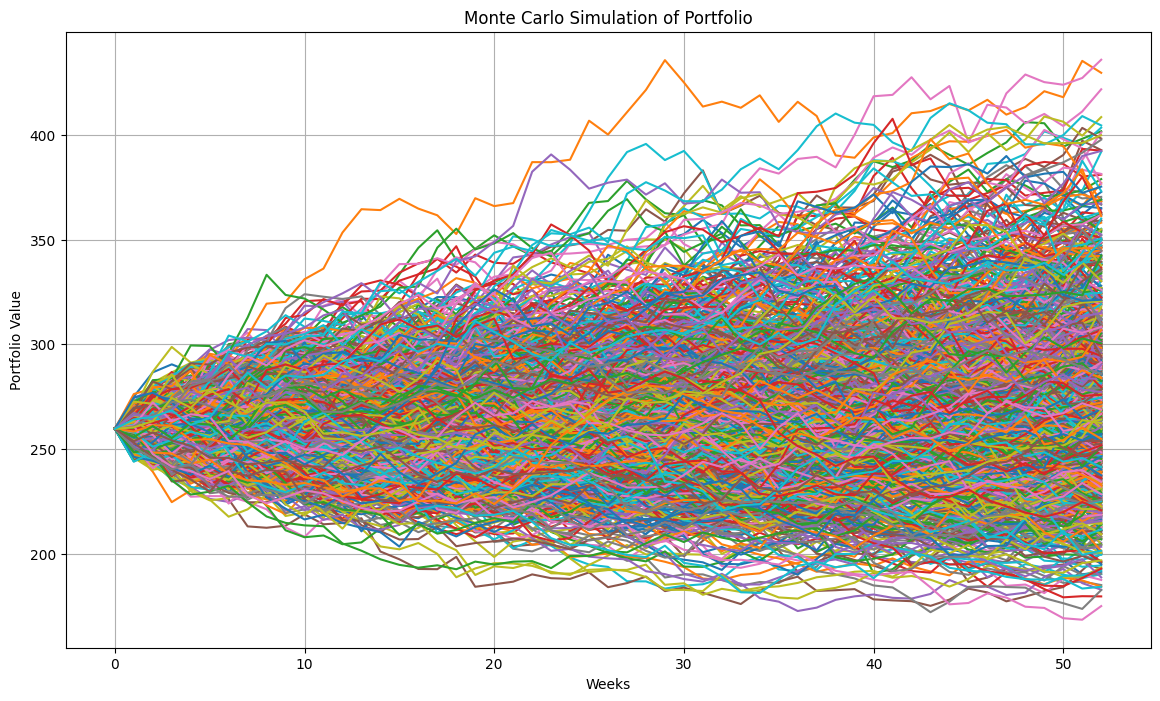

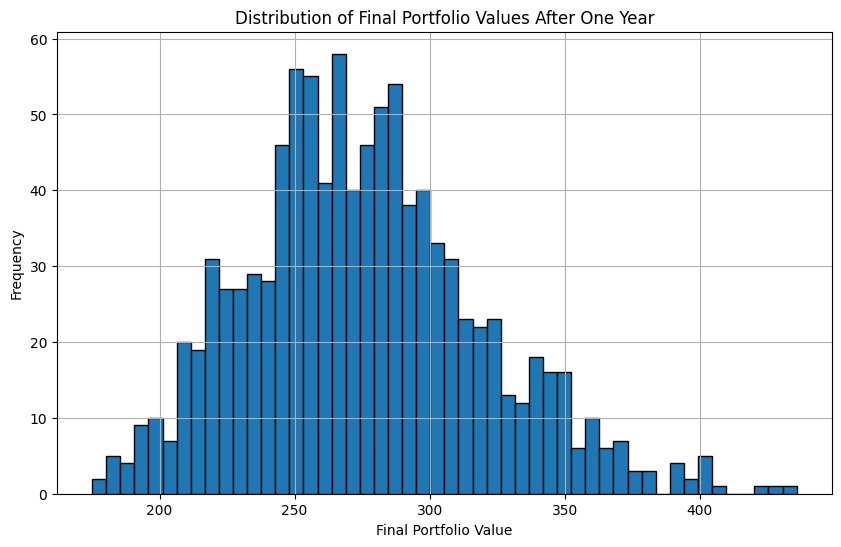

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load and preprocess the data
def load_data(file_path, sheet_name):
    data = pd.read_excel(file_path, sheet_name=sheet_name)
    data['Dates'] = pd.to_datetime(data['Dates'])
    data.set_index('Dates', inplace=True)
    data.drop(columns=[col for col in data.columns if 'Unnamed' in col], inplace=True)
    data = data.resample('W').ffill()
    data['CPI Change'] = data['CPI YoY'].diff().fillna(0)
    data['Benchmark'] = 0.6 * data['S&P500'] + 0.4 * data['U.S. Bonds']
    return data

# Define the rotation strategy
def rotation_strategy(row, sectors, cpi_change):
    weights = np.array([1/len(sectors)] * len(sectors))
    if cpi_change > 0.0:
        adjust_defensive = np.isin(sectors, ['Util', 'Telco', 'ConsStap', 'Health', 'Energy'])
        weights[adjust_defensive] += 0.02
        weights[~adjust_defensive] -= 0.02
    if cpi_change < 0.0:
        adjust_growth = np.isin(sectors, ['InfoTech', 'Materials', 'Industr', 'ConsDis', 'Finance'])
        weights[adjust_growth] += 0.02
        weights[~adjust_growth] -= 0.02
    weights = np.clip(weights, 0, None)
    weights /= weights.sum()
    return pd.Series(weights, index=sectors)

# Apply the rotation strategy
def calculate_weights(data, sectors):
    return data.apply(lambda row: rotation_strategy(row, sectors, row['CPI YoY']), axis=1)

# Calculate sector returns and apply weights
def calculate_portfolio_returns(data, weights_data, sectors):
    sector_returns = data[sectors].pct_change().fillna(0)
    weighted_sector_returns = sector_returns * weights_data.shift()  # Apply weights from the previous period
    data['Total Weighted Returns'] = weighted_sector_returns.sum(axis=1)
    return data

# Initialize Portfolio Value
def initialize_portfolio(data, initial_investment=100000):
    data['Portfolio Value'] = initial_investment * (1 + data['Total Weighted Returns']).cumprod()
    return data

# Calculate performance metrics
def calculate_performance_metrics(data):
    data['Portfolio Returns'] = data['Portfolio Value'].pct_change().fillna(0)
    data['Cumulative Portfolio Returns'] = (1 + data['Portfolio Returns']).cumprod() - 1
    data['Benchmark Returns'] = data['Benchmark'].pct_change().fillna(0)
    data['Cumulative Benchmark Returns'] = (1 + data['Benchmark Returns']).cumprod() - 1

    # Total return
    initial_value = data['Portfolio Value'].iloc[0]
    final_value = data['Portfolio Value'].iloc[-1]
    total_return = ((final_value - initial_value) / initial_value) * 100

    # Annualized return (CAGR)
    total_days = (data.index[-1] - data.index[0]).days
    years = total_days / 365.25
    annualized_return = ((final_value / initial_value) ** (1 / years) - 1) * 100

    # Sharpe ratio
    def calculate_sharpe_ratio(returns, risk_free_rate=0):
        mean_return = returns.mean() * 52  # Annualizing the mean return
        std_dev = returns.std() * np.sqrt(52)  # Annualizing the standard deviation
        sharpe_ratio = (mean_return - risk_free_rate) / std_dev if std_dev != 0 else 0
        return sharpe_ratio

    sharpe_ratio = calculate_sharpe_ratio(data['Portfolio Returns'])

    # Volatility (annualized)
    volatility = data['Portfolio Returns'].std() * np.sqrt(52) * 100  # Annualized volatility in percentage

    # Maximum drawdown
    def calculate_maximum_drawdown(values):
        cumulative_returns = values / values.iloc[0] - 1
        running_max = cumulative_returns.cummax()
        drawdowns = cumulative_returns - running_max
        max_drawdown = drawdowns.min()
        return max_drawdown

    max_drawdown = calculate_maximum_drawdown(data['Portfolio Value'])

    # Benchmark metrics
    benchmark_initial_value = data['Benchmark'].iloc[0]
    benchmark_final_value = data['Benchmark'].iloc[-1]
    benchmark_total_return = ((benchmark_final_value - benchmark_initial_value) / benchmark_initial_value) * 100
    benchmark_annualized_return = ((benchmark_final_value / benchmark_initial_value) ** (1 / years) - 1) * 100
    benchmark_sharpe_ratio = calculate_sharpe_ratio(data['Benchmark Returns'])
    benchmark_volatility = data['Benchmark Returns'].std() * np.sqrt(52) * 100
    benchmark_max_drawdown = calculate_maximum_drawdown(data['Benchmark'])

    # Alpha and Beta
    covariance_matrix = np.cov(data['Portfolio Returns'], data['Benchmark Returns'])
    beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
    alpha = (data['Portfolio Returns'].mean() * 52) - ((data['Benchmark Returns'].mean() * 52))

    return (total_return, annualized_return, sharpe_ratio, volatility, max_drawdown, alpha, beta,
            benchmark_total_return, benchmark_annualized_return, benchmark_sharpe_ratio, benchmark_volatility, benchmark_max_drawdown)

# Plotting function
def plot_results(data):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Cumulative Portfolio Returns'], label='Cumulative Portfolio Returns', color='blue')
    plt.plot(data.index, data['Cumulative Benchmark Returns'], label='Cumulative Benchmark Returns', color='green')
    plt.title('Cumulative Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

# Full backtesting function
def backtest_portfolio(file_path, sheet_name, sectors, initial_investment=100000):
    data = load_data(file_path, sheet_name)
    weights_data = calculate_weights(data, sectors)
    data = calculate_portfolio_returns(data, weights_data, sectors)
    data = initialize_portfolio(data, initial_investment)
    (total_return, annualized_return, sharpe_ratio, volatility, max_drawdown, alpha, beta,
     benchmark_total_return, benchmark_annualized_return, benchmark_sharpe_ratio, benchmark_volatility, benchmark_max_drawdown) = calculate_performance_metrics(data)
    plot_results(data)

    print(f"Total Return of the Portfolio: {total_return:.2f}%")
    print(f"Annualized Return of the Portfolio: {annualized_return:.2f}%")
    print(f"Sharpe Ratio of the Portfolio: {sharpe_ratio}")
    print(f"Volatility of the Portfolio: {volatility:.2f}%")
    print(f"Maximum Drawdown of the Portfolio: {max_drawdown:.2%}")
    print(f"Alpha of the Portfolio: {alpha:.2f}%")
    print(f"Beta of the Portfolio: {beta:.2f}")

    print(f"Total Return of the Benchmark: {benchmark_total_return:.2f}%")
    print(f"Annualized Return of the Benchmark: {benchmark_annualized_return:.2f}%")
    print(f"Sharpe Ratio of the Benchmark: {benchmark_sharpe_ratio}")
    print(f"Volatility of the Benchmark: {benchmark_volatility:.2f}%")
    print(f"Maximum Drawdown of the Benchmark: {benchmark_max_drawdown:.2%}")

# Define sectors
sectors = ['InfoTech', 'Util', 'Energy', 'Materials', 'Industr', 'Telco', 'ConsStap', 'ConsDis', 'Health', 'Finance']

# Run the backtest
file_path = '/content/CAPSTONE DATA Ty Miller QUANT 1.xlsx'
sheet_name = 'DataTestNorm100'
backtest_portfolio(file_path, sheet_name, sectors)

# Monte Carlo Simulation

# Parameters for the Monte Carlo simulation
num_simulations = 1000  # Number of simulated paths
num_weeks = 52  # Number of weeks to simulate (one trading year)

# Historical mean and standard deviation of weekly returns
mean_return = data['Portfolio Returns'].mean()
std_dev_return = data['Portfolio Returns'].std()

# Initialize a DataFrame to store the simulation results
simulation_df = pd.DataFrame()

# Loop to simulate each path
for x in range(num_simulations):
    weekly_returns = np.random.normal(mean_return, std_dev_return, num_weeks)
    portfolio_values = [data['Portfolio Value'].iloc[-1]]  # Start with the last known portfolio value

    for r in weekly_returns:
        portfolio_values.append(portfolio_values[-1] * (1 + r))

    simulation_df[x] = portfolio_values

# Plot the simulation results
plt.figure(figsize=(14, 8))
plt.plot(simulation_df)
plt.title('Monte Carlo Simulation of Portfolio')
plt.xlabel('Weeks')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

# Plot a histogram of the final portfolio values
plt.figure(figsize=(10, 6))
plt.hist(simulation_df.iloc[-1, :], bins=50, edgecolor='black')
plt.title('Distribution of Final Portfolio Values After One Year')
plt.xlabel('Final Portfolio Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()